In [6]:
import gymnasium as gym
from gymnasium import spaces

# PyTorch imports
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
if torch.cuda.is_available():
  device = "cuda" 
else:
  device = "cpu"
print(device, " in use")

# Utility librarues
import base64, io
import random
import pickle
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

cuda  in use


/tmp/ipykernel_13476/4139666265.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [13]:
env = gym.make('CartPole-v1')

obs_space = 4
action_space = 2

# Actor Network

In [23]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(obs_space, 128)
        self.hidden = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_space) # action probabilities

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.hidden(x))
        action_prob = F.softmax(self.out(x), dim=-1)
        return action_prob


# Q Critic Network

In [24]:
class Q_Critic(nn.Module):
    def __init__(self):
        super(Q_Critic, self).__init__()
        self.layer1 = nn.Linear(obs_space + action_space, 128)
        self.hidden = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1) # action probabilities

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.hidden(x))
        Q_val = F.relu(self.out(x))
        return Q_val

In [56]:
def give_action(obs, Actor_model):
    obs = torch.from_numpy(obs).float()
    probs = Actor_model(obs)
    dist = Categorical(probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)

    return action.item(), log_prob


In [57]:
def give_Qsa(obs, action, Qsa_model):
    action_arr = np.eye(action_space)[action].reshape(-1)
    inp = np.concatenate((obs, action_arr))
    inp = np.reshape(inp, -1)
    inp = torch.from_numpy(inp).float()
    Qval = Qsa_model(inp)
    return Qval

In [58]:
Actor_model = Actor()
Qsa_model = Q_Critic()
Actor_lr = 0.001
Actor_optim = optim.Adam(Actor_model.parameters(), lr = Actor_lr)
Qsa_lr = 0.001
Qsa_optim = optim.Adam(Qsa_model.parameters(), lr = Qsa_lr)

In [59]:
max_itr = 1000
gamma = 0.7

In [62]:
## Reset
obs, info = env.reset()
terminated, truncated = False, False

# for one episode
Actor_loss = []
Critic_loss = []
Qsa_prev = 0
for i in range(max_itr):
    action, log_prob = give_action(obs, Actor_model)
    Qsa = give_Qsa(obs, action, Qsa_model)
    Actor_loss.append( - log_prob*Qsa )
    obs, reward, terminated, truncated, info = env.step(action)
    delt = reward + gamma*Qsa - Qsa_prev
    Critic_loss.append( delt*Qsa )
    Qsa_prev = Qsa

    if truncated or terminated:
        break

#Backpropagation

Actor_optim.zero_grad()
Actor_loss_T = torch.stack(Actor_loss).sum()
Actor_loss_T.backward()
Actor_optim.step()

Qsa_optim.zero_grad()
Critic_loss_T = torch.stack(Critic_loss).sum()
Critic_loss_T.backward()
Qsa_optim.step()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

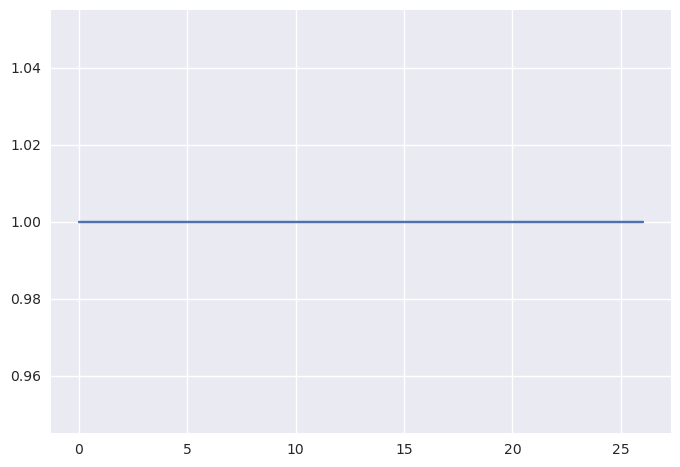

array([[1., 0.]])